In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from features import lat_lng2dist_ang
from cmdstanpy import CmdStanModel, set_cmdstan_path
import contextily as ctx
import os
import arviz as az

sns.set_theme()

GEOLOCATION = "unil"
TRANSFORMED_CSV = f"datasets/processed/{GEOLOCATION}/transformed.csv"
GT_POINTS_CSV = f"datasets/raw/{GEOLOCATION}/gt_points.csv"
CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
STAN_MODEL_PATH = "bivariate_normal.stan"

set_cmdstan_path(CMDSTAN_PATH)


transformed_df = pd.read_csv(TRANSFORMED_CSV)
gt_points_df = pd.read_csv(GT_POINTS_CSV)
gt_points_df["plot_label"] = gt_points_df["name"]
transformed_df["plot_label"] = transformed_df["measured_from"] + " measurements"

/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gt_points_df

,name,lat,lng,plot_label
0,P1,46.521592,6.573832,P1
1,P2,46.521955,6.575116,P2
2,E,46.521331,6.573944,E


In [3]:
transformed_df

,measured_from,lat,lng,distance,angle_rad,angle_deg,plot_label
0,P1,46.521344,6.573931,28.567320,2.873785,164.655746,P1 measurements
1,P1,46.521408,6.573775,20.910190,3.352463,192.082006,P1 measurements
2,P1,46.521381,6.573844,23.554072,3.101168,177.683850,P1 measurements
3,P1,46.521361,6.573889,26.063941,2.973435,170.365252,P1 measurements
4,P1,46.521386,6.573825,22.923629,3.165157,181.350112,P1 measurements
...,...,...,...,...,...,...,...
195,P2,46.521892,6.574633,37.719201,4.525284,259.279701,P2 measurements
196,P2,46.521919,6.574689,33.032434,4.593177,263.169673,P2 measurements
197,P2,46.521922,6.574756,27.918201,4.582366,262.550258,P2 measurements
198,P2,46.521928,6.574819,22.977217,4.581353,262.492195,P2 measurements


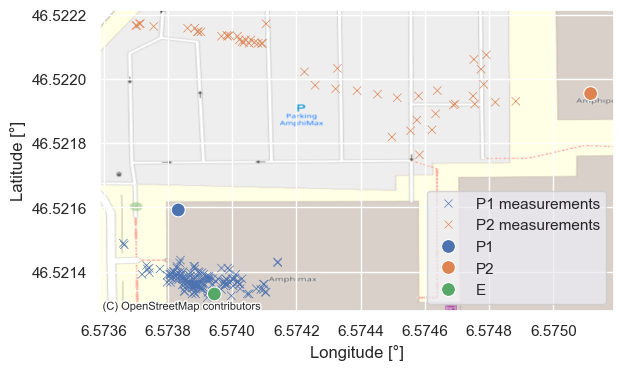

In [4]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=transformed_df, x="lng", y="lat", hue="plot_label", ax=ax, marker="x"
)
sns.scatterplot(data=gt_points_df, x="lng", y="lat", hue="plot_label", ax=ax, s=100)
ctx.add_basemap(ax, crs="epsg:4326", source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
# disable scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.legend(title="")
# Save the plot
plt.tight_layout()
plt.savefig(f"figs/{GEOLOCATION}_geomap.png")

In [5]:
P1_lat, P1_lng = (
    gt_points_df[gt_points_df["name"] == "P1"][["lat", "lng"]].values[0].tolist()
)
P2_lat, P2_lng = (
    gt_points_df[gt_points_df["name"] == "P2"][["lat", "lng"]].values[0].tolist()
)
E_lat, E_lng = (
    gt_points_df[gt_points_df["name"] == "E"][["lat", "lng"]].values[0].tolist()
)
E_P1_dist, E_P1_angle_rad, E_P1_angle_deg = lat_lng2dist_ang(
    [P1_lat, P1_lng], [E_lat, E_lng]
)
E_P2_dist, E_P2_angle_rad, E_P2_angle_deg = lat_lng2dist_ang(
    [P2_lat, P2_lng], [E_lat, E_lng]
)

print(f"P1: {P1_lat}, {P1_lng}")
print(f"P2: {P2_lat}, {P2_lng}")
print(f"E: {E_lat}, {E_lng}")
print(
    f"E using P1 as the center: dist={E_P1_dist}, angle_rad={E_P1_angle_rad}, angle_deg={E_P1_angle_deg}"
)
print(
    f"E using P2 as the center: dist={E_P2_dist}, angle_rad={E_P2_angle_rad}, angle_deg={E_P2_angle_deg}"
)


P1: 46.521592273, 6.573832039
P2: 46.521954786, 6.575116326
E: 46.521330555, 6.573944444
E using P1 as the center: dist=30.344572744546294, angle_rad=2.8533795973322875, angle_deg=163.48660827587835
E using P2 as the center: dist=113.5817863518005, angle_rad=4.055162326777971, angle_deg=232.34368656482852


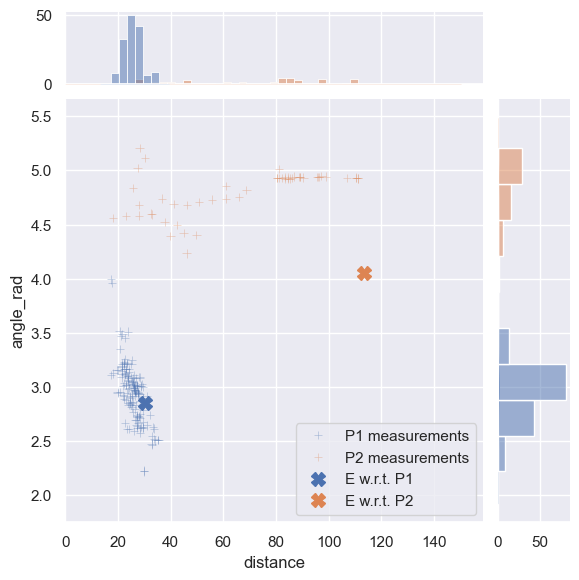

In [6]:
#! P1(measured) and P2(measured) are measurements that are transformed to dist and angle WITH RESPECT TO THEIR GROUND TRUTH (P1 or P2)
g = sns.jointplot(
    data=transformed_df,
    x="distance",
    y="angle_rad",
    hue="plot_label",
    kind="scatter",
    marginal_ticks=True,
    joint_kws={"marker": "+"},
    alpha=0.4
)

# lower bound for distance is 0
g.ax_joint.set_xlim(left=0)
g.plot_marginals(sns.histplot)

proposals = gt_points_df["name"].values.tolist()
proposals.remove("E")

for proposal_name in proposals:
    proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][
        ["lat", "lng"]
    ].values[0]
    dist, angle_rad, _ = lat_lng2dist_ang(proposal_lat_lng, [E_lat, E_lng])
    g.ax_joint.plot(
        dist, angle_rad, "X", label=f"E w.r.t. {proposal_name}", markersize=10
    )
g.ax_joint.legend()

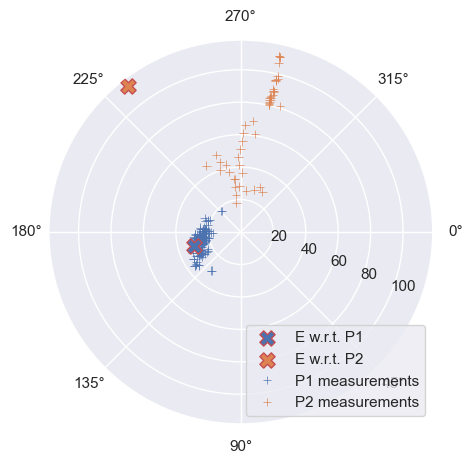

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

for proposal_name in proposals:
    proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][
        ["lat", "lng"]
    ].values[0]
    dist, angle_rad, _ = lat_lng2dist_ang(proposal_lat_lng, [E_lat, E_lng])
    ax.scatter(angle_rad, dist, marker="X", label=f"E w.r.t. {proposal_name}", s=120, edgecolors='r', zorder=10)


sns.scatterplot(
    data=transformed_df,
    x="angle_rad",
    y="distance",
    hue="plot_label",
    ax=ax,
    marker="+",
    # alpha=0.5,
)
# ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
# ax.set_rlabel_position(0)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.legend(title="", loc="lower right")
plt.tight_layout()
plt.savefig(f"figs/{GEOLOCATION}_polar.pdf")

In [8]:
stan_data = {
    "N1": transformed_df[transformed_df["measured_from"] == "P1"].shape[0],
    "N2": transformed_df[transformed_df["measured_from"] == "P2"].shape[0],
    "y1": transformed_df[transformed_df["measured_from"] == "P1"][
        ["distance", "angle_rad"]
    ].values.tolist(),
    "y2": transformed_df[transformed_df["measured_from"] == "P2"][
        ["distance", "angle_rad"]
    ].values.tolist(),
    "E_p1": [E_P1_dist, E_P1_angle_rad],
    "E_p2": [E_P2_dist, E_P2_angle_rad],
}


model = CmdStanModel(stan_file=STAN_MODEL_PATH)
fit = model.sample(
    data=stan_data,
    chains=4,
    iter_warmup=1000,
    iter_sampling=4000,
    seed=1,
    parallel_chains=os.cpu_count(),
)

display(fit.summary())
print(fit.diagnose())

00:31:18 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
00:31:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Iteration:    1 / 5000 [  0%]  (Warmup)



chain 1 |▌         | 00:00 Iteration:  100 / 5000 [  2%]  (Warmup)


chain 1 |█▏        | 00:00 Iteration:  400 / 5000 [  8%]  (Warmup)

chain 1 |█▉        | 00:00 Iteration:  800 / 5000 [ 16%]  (Warmup)


chain 1 |██▌       | 00:00 Iteration: 1001 / 5000 [ 20%]  (Sampling)


chain 1 |███       | 00:01 Iteration: 1300 / 5000 [ 26%]  (Sampling)


chain 1 |███▋      | 00:01 Iteration: 1600 / 5000 [ 32%]  (Sampling)


chain 1 |████      | 00:01 Iteration: 1800 / 5000 [ 36%]  (Sampling)


chain 1 |████▍     | 00:01 Iteration: 2000 / 5000 [ 40%]  (Sampling)


chain 1 |████▊     | 00:01 Iteration: 2200 / 5000 [ 44%]  (Sampling)


chain 1 |█████▏    | 00:01 Iteration: 2400 / 5000 [ 48%]  (Sampling)


chain 1 |█████▌    | 00:


00:31:21 - cmdstanpy - INFO - CmdStan done processing.
00:31:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'bivariate_normal.stan', line 21, column 2 to column 34)
	Exception: lkj

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-224.11600,0.026014,2.231970,-228.22700,-223.79200,-221.07900,7361.16,597.061,1.000080
mu1[1],25.71520,0.002643,0.294936,25.22860,25.71490,26.20570,12452.80,1010.040,0.999819
mu1[2],2.94607,0.000193,0.021812,2.90996,2.94606,2.98192,12823.20,1040.080,0.999861
mu2[1],66.95930,0.031515,4.137290,60.15340,66.94620,73.79330,17234.40,1397.880,0.999977
mu2[2],4.81051,0.000219,0.029008,4.76293,4.81058,4.85748,17587.40,1426.500,0.999862
...,...,...,...,...,...,...,...,...,...
"y2_rep[49,2]",4.80974,0.001679,0.211439,4.46533,4.80741,5.15600,15855.20,1286.010,0.999904
"y2_rep[50,1]",66.98650,0.237857,29.842100,17.99980,66.82050,115.24800,15740.70,1276.720,0.999934
"y2_rep[50,2]",4.80958,0.001711,0.212068,4.46267,4.80793,5.15871,15360.80,1245.900,1.000140
"y2_rep[51,1]",66.80220,0.237826,29.644600,18.36920,66.70810,115.98400,15537.20,1260.220,0.999928


Processing csv files: /tmp/tmp79o0d16n/bivariate_normalaxr_jyby/bivariate_normal-20240901003118_1.csv, /tmp/tmp79o0d16n/bivariate_normalaxr_jyby/bivariate_normal-20240901003118_2.csv, /tmp/tmp79o0d16n/bivariate_normalaxr_jyby/bivariate_normal-20240901003118_3.csv, /tmp/tmp79o0d16n/bivariate_normalaxr_jyby/bivariate_normal-20240901003118_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'mu2\n0'}>,
        <Axes: title={'center': 'mu2\n0'}>],
       [<Axes: title={'center': 'mu2\n1'}>,
        <Axes: title={'center': 'mu2\n1'}>]], dtype=object)

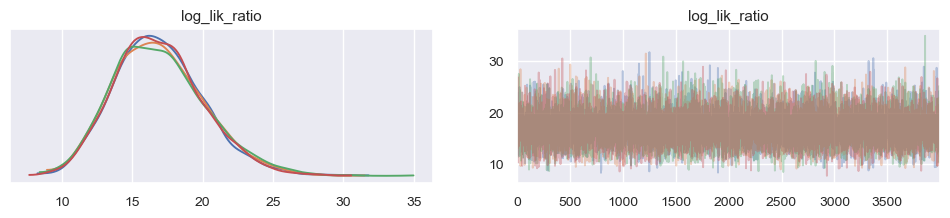

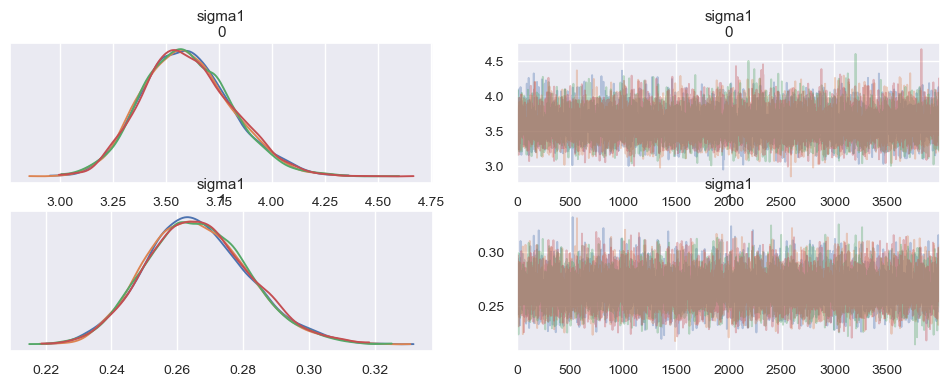

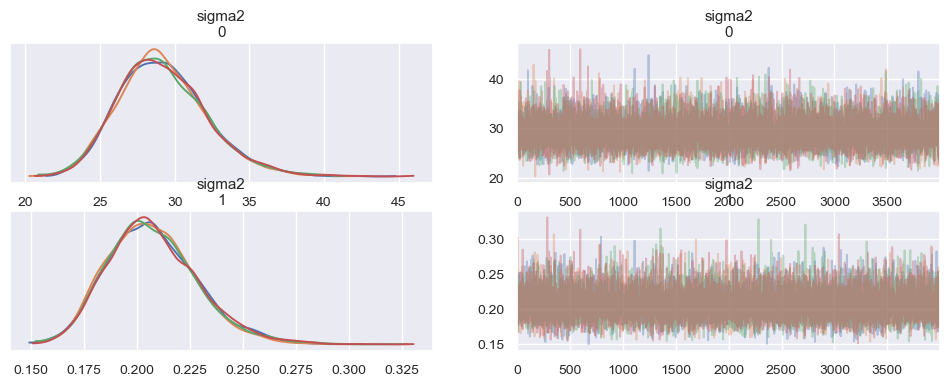

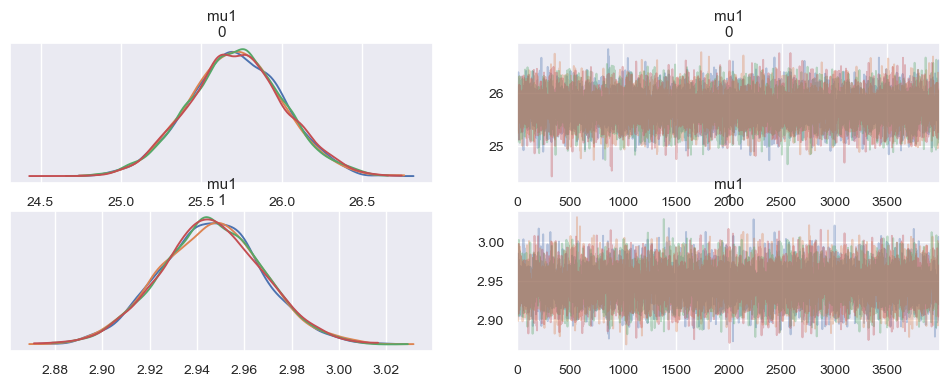

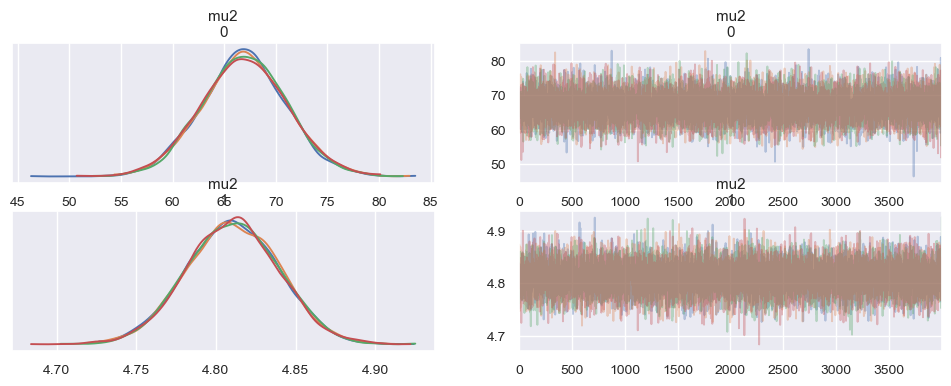

In [9]:
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="log_lik_ratio")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^sigma1")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^sigma2")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^mu1")
az.plot_trace(fit, compact=False, filter_vars="regex", var_names="^mu2")

(16000, 149, 2)
(16000, 51, 2)
(5, 149, 2)
(5, 51, 2)


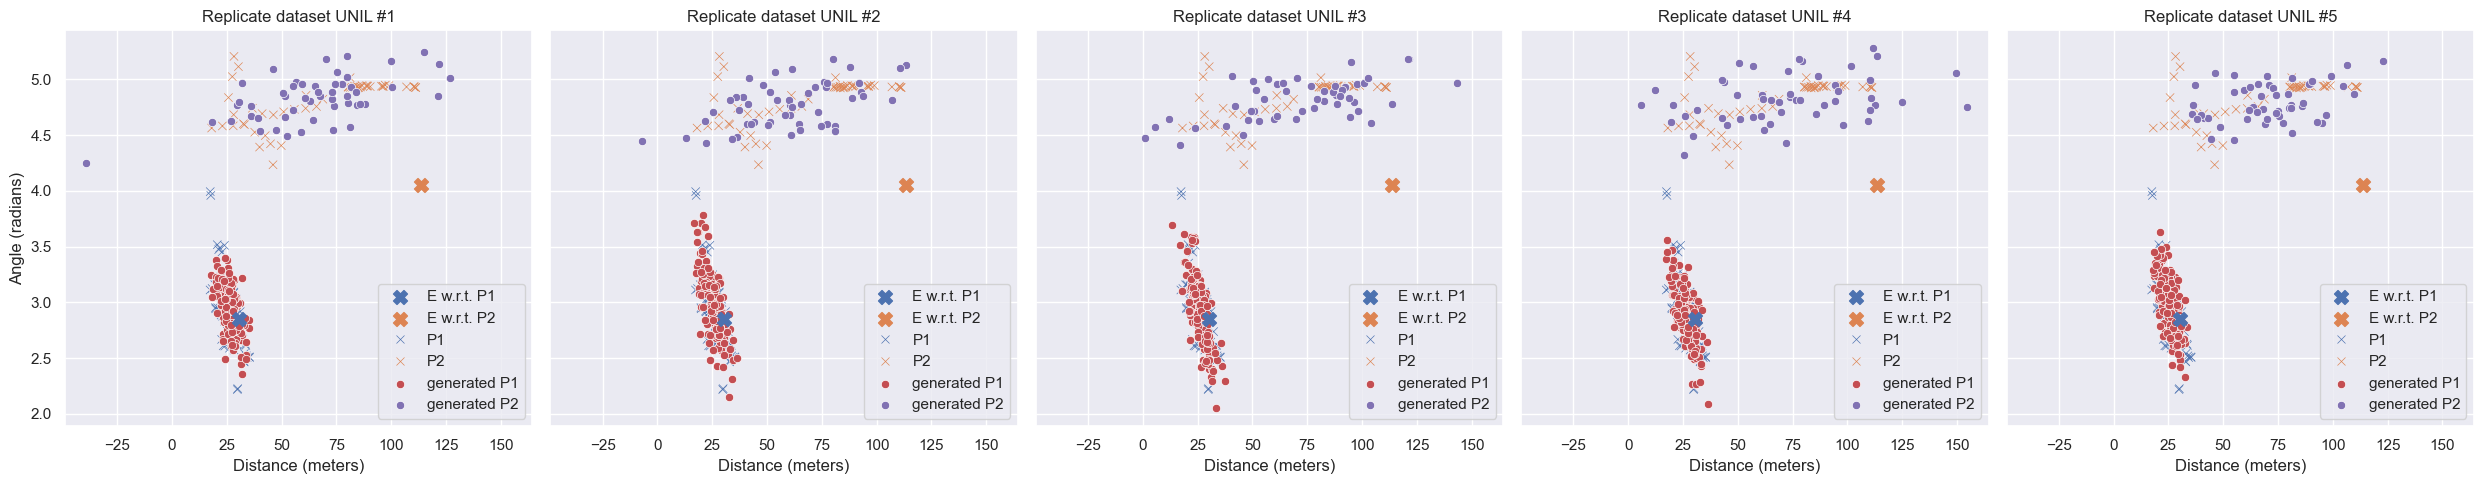

In [10]:
replicate_datasets_p1 = fit.y1_rep
print(replicate_datasets_p1.shape) # n_draws x n_measurements_p1 x 2 (distance, angle_rad)
replicate_datasets_p2 = fit.y2_rep
print(replicate_datasets_p2.shape) # n_draws x n_measurements_p2 x 2 (distance, angle_rad)

# randomly select n_replicate replicate datasets for each proposal
n_replicates = 5
replicate_indices = np.random.choice(
    replicate_datasets_p1.shape[0], n_replicates, replace=False
)
replicate_datasets_p1 = replicate_datasets_p1[replicate_indices]
replicate_datasets_p2 = replicate_datasets_p2[replicate_indices]
print(replicate_datasets_p1.shape)
print(replicate_datasets_p2.shape)

# plot the posterior predictive
fig, ax = plt.subplots(
    1, n_replicates, figsize=(n_replicates * 5, 5), sharex=True, sharey=True
)
for i in range(n_replicates):
    ax[i].scatter(E_P1_dist, E_P1_angle_rad, label="E w.r.t. P1", marker="X", s=100, zorder=10)
    ax[i].scatter(E_P2_dist, E_P2_angle_rad, label="E w.r.t. P2", marker="X", s=100, zorder=10)
    sns.scatterplot(
        data=transformed_df,
        x="distance",
        y="angle_rad",
        hue="measured_from",
        ax=ax[i],
        marker="x",
    )
    sns.scatterplot(
        data=pd.DataFrame(replicate_datasets_p1[i], columns=["distance", "angle_rad"]),
        x="distance",
        y="angle_rad",
        ax=ax[i],
        label="generated P1",
    )
    sns.scatterplot(
        data=pd.DataFrame(replicate_datasets_p2[i], columns=["distance", "angle_rad"]),
        x="distance",
        y="angle_rad",
        ax=ax[i],
        label="generated P2",
    )
    
    ax[i].set_title(f"Replicate dataset UNIL #{i + 1}")
    ax[i].set_xlabel("Distance (meters)")
    ax[i].set_ylabel("Angle (radians)")
    ax[i].legend()

plt.tight_layout()
plt.savefig(f"figs/{GEOLOCATION}_posterior_predictive.pdf")


Mean log likelihood ratio: 16.901780226874997 +- 0.01968474345782821, 95% HDI: [11.0204 23.481 ]


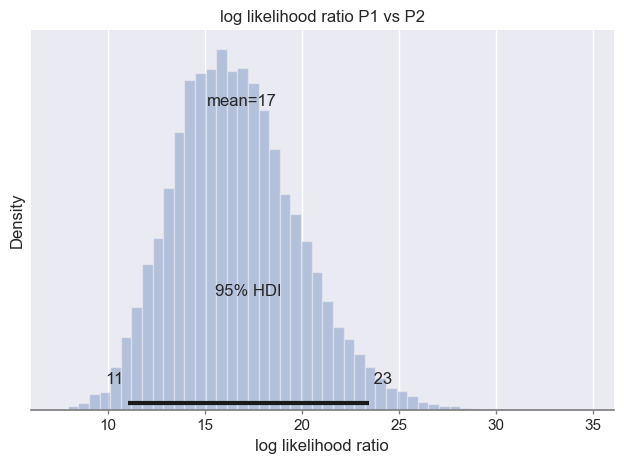

In [11]:
ax = az.plot_posterior(fit, var_names=["log_lik_ratio"], kind="hist", hdi_prob=0.95, bins=50)
ax.set_xlabel("log likelihood ratio")
ax.set_ylabel("Density")
ax.axis("on")
ax.set_title("log likelihood ratio P1 vs P2")

plt.tight_layout()
plt.savefig(f"figs/{GEOLOCATION}_log_lik_ratio.pdf")

log_lik_ratio = fit.log_lik_ratio
mean_lr = np.mean(log_lik_ratio)
mcse_lr = az.stats.mcse(log_lik_ratio)

print(
    f"Mean log likelihood ratio: {mean_lr} +- {mcse_lr}, 95% HDI: {az.hdi(log_lik_ratio, hdi_prob=0.95)}"
)